In [1]:
from proxy_methods_final import *
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
import scipy.stats as stats
from scipy.stats import binom_test

/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

# Load data
---

In [3]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/new_reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/new_metadata_after_aggregation.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/new_eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_92039/1350122294.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


# Generate proxy data
---

In [4]:
#Get matching dates in price data and index data
#-----------------------------------------
price_dates = prices_data.index.tolist()

#Extract date portion of the datetime object in the price data
index_dates = index_data['Date'].tolist()

matching_dates = [date for date in price_dates if date in index_dates]

print(len(matching_dates))


2515


In [ ]:
tickers = prices_data.columns.to_list() 

# #ALEX DATES
# #-----------
dates = matching_dates[0:839]

# # #CALVIN DATES
# # dates = matching_dates[839:1678] 

# # #VINAYS DATES
# dates = matching_dates[1678:1683] 

proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)
proxy_time_series_df.to_csv('data/proxy_time_series_alex_final.csv', index=False)

In [ ]:
proxy_time_series_final = pd.read_csv('data/proxy_time_series_final.csv')

dates = proxy_time_series_final['Date'].unique().tolist()

print(len(dates))

2515


# Error curves
---

In [5]:
error_type='MAPE'
error_intersection_normal_list, error_intersection_communities_list, error_csra_normal_list, error_csra_communities_list = calculate_error_curves(proxy_time_series_filtered, dates,error_type=error_type)

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:764: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])


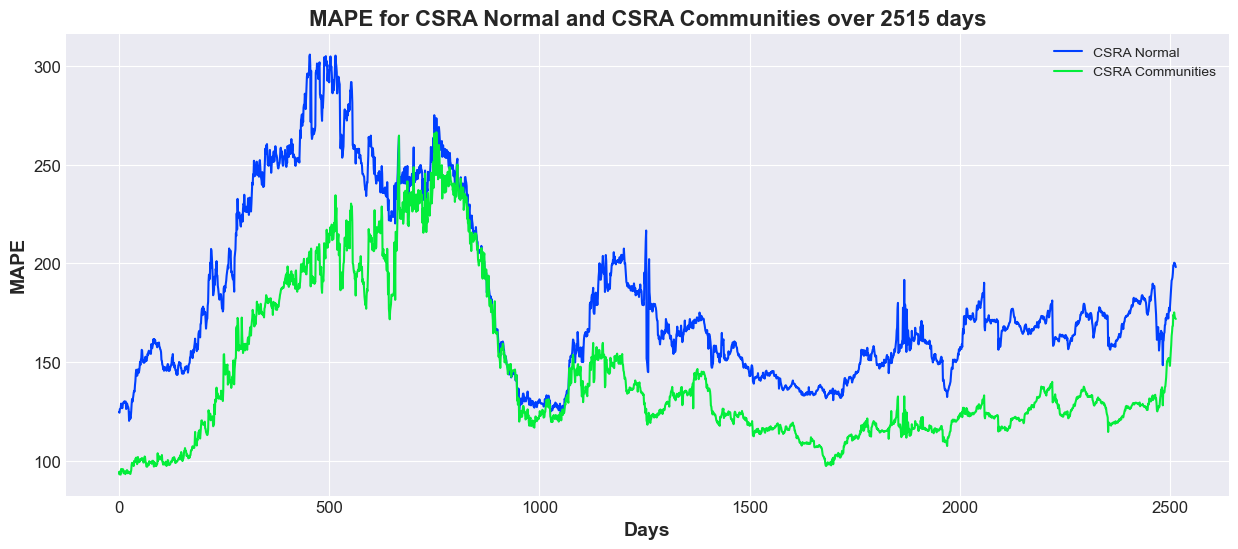

In [6]:
plot_error_curves(error_csra_normal_list, error_csra_communities_list, dates, method='CSRA', error_type='MAPE')

In [7]:
calculate_percentage_better(error_csra_normal_list, error_csra_communities_list)

Number of days where RMSE for normal CSRA method > RMSE for community CSRA method : 2484
Percentage of days where CSRA Communities method is better: 98.76739562624255%


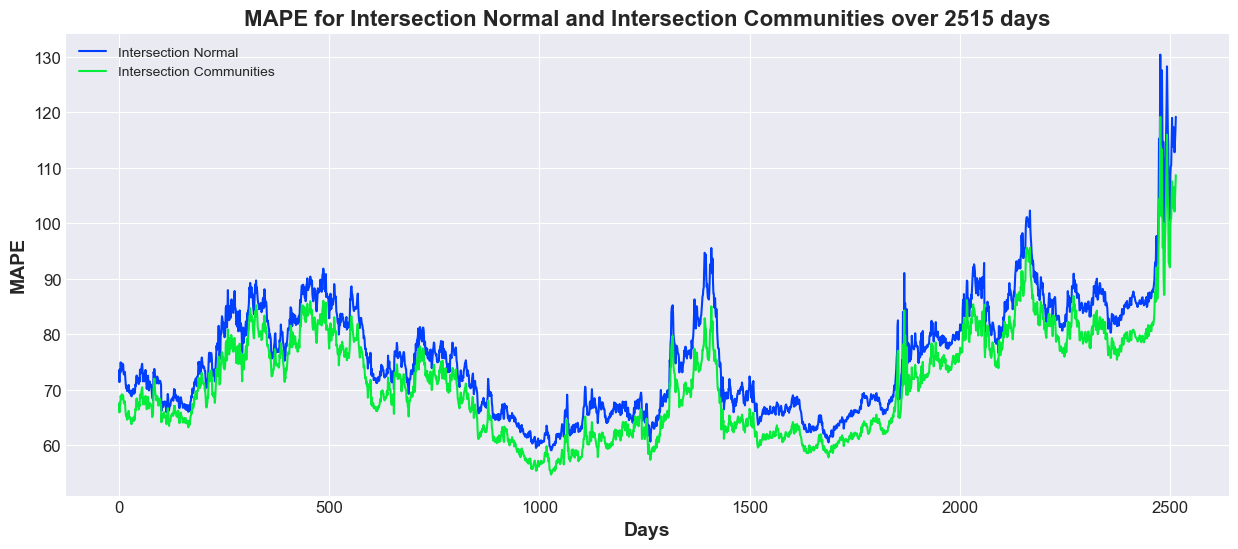

In [8]:
plot_error_curves(error_intersection_normal_list, error_intersection_communities_list, dates, method='Intersection', error_type='MAPE')

In [9]:
calculate_percentage_better(error_intersection_normal_list, error_intersection_communities_list)

Number of days where RMSE for normal CSRA method > RMSE for community CSRA method : 2515
Percentage of days where CSRA Communities method is better: 100.0%


In [10]:
#Plot average spread each day with shaded area of 1 standard deviation

average_spreads = []
std_spreads = []

for date in dates:
    proxy_time_series_filtered_date = proxy_time_series_filtered[proxy_time_series_filtered['Date'] == date]
    average_spread = np.mean(proxy_time_series_filtered_date['Actual_Spread'])
    std_spread = np.std(proxy_time_series_filtered_date['Actual_Spread'])
    average_spreads.append(average_spread)
    std_spreads.append(std_spread)

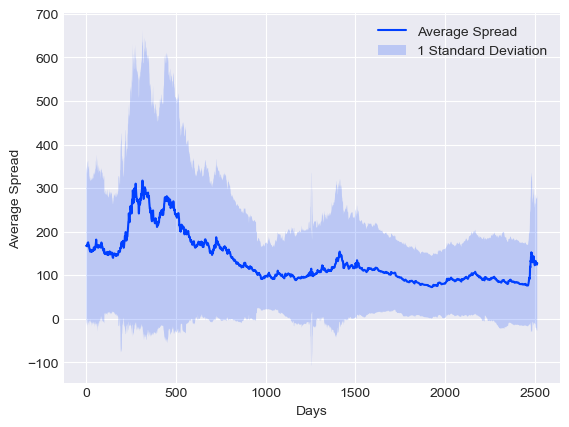

In [11]:
num_days = [i for i in range(len(dates))]
plt.plot(num_days, average_spreads, label='Average Spread')
plt.fill_between(num_days, np.array(average_spreads) - np.array(std_spreads), np.array(average_spreads) + np.array(std_spreads), alpha=0.2, label='1 Standard Deviation')
plt.xlabel('Days')
plt.ylabel('Average Spread')
plt.legend()


# Hypothesis testing
---

### Check distributions

/Users/alex_1/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


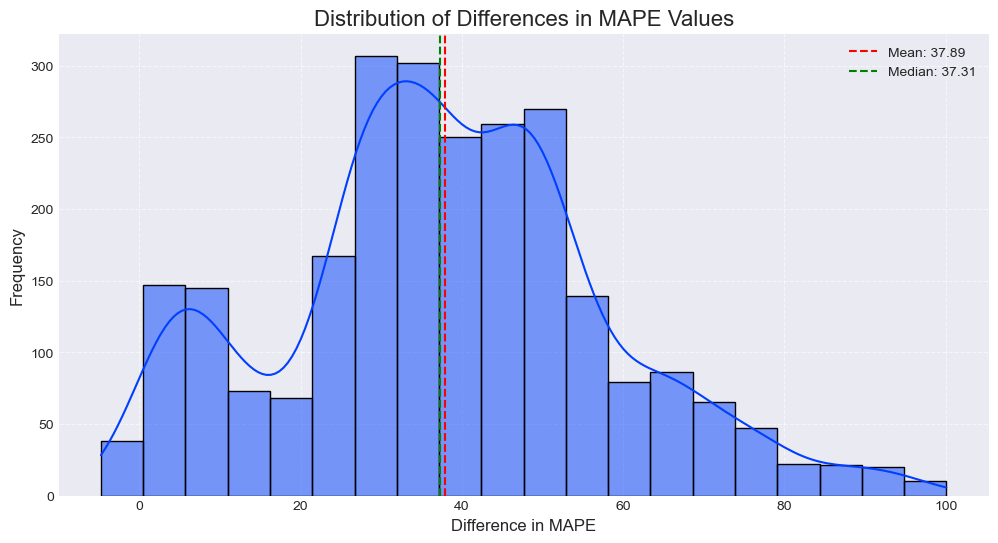

In [12]:
#CSRA 

plot_difference_distribution(error_csra_normal_list, error_csra_communities_list, error_type='MAPE')

/Users/alex_1/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


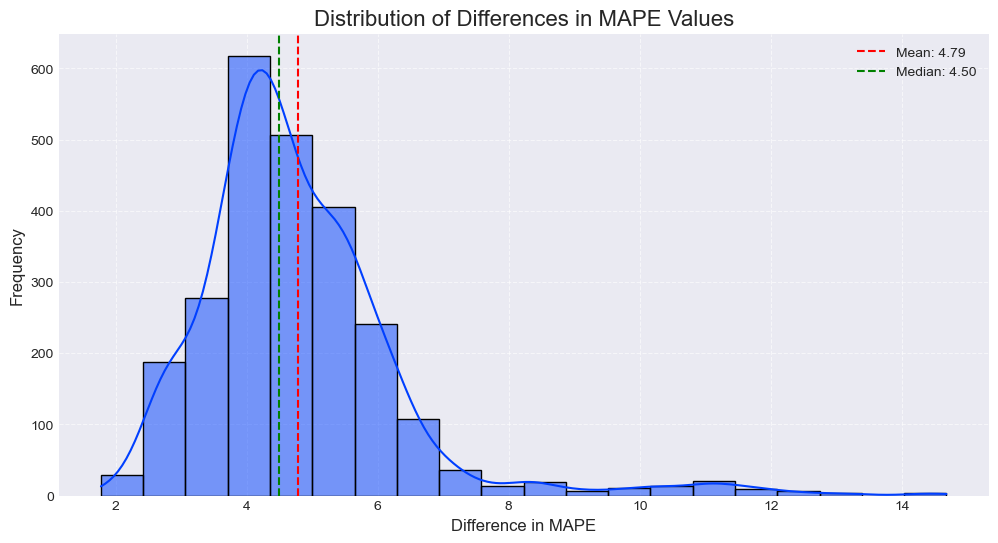

In [13]:
#Intersection

plot_difference_distribution(error_intersection_normal_list, error_intersection_communities_list, error_type='MAPE')


### Perfrom Shapiro-Wilk test for normality

In [14]:
#CSRA
shapiro_wilk_test(error_csra_normal_list, error_csra_communities_list)

Shapiro-Wilk Test Statistic: 0.9848
Shapiro-Wilk Test p-value: 0.0000
Reject the null hypothesis: The differences are not normally distributed.


In [15]:
#Intersection
shapiro_wilk_test(error_intersection_normal_list, error_intersection_communities_list)

Shapiro-Wilk Test Statistic: 0.8426
Shapiro-Wilk Test p-value: 0.0000
Reject the null hypothesis: The differences are not normally distributed.


### Perform sign test 

In [16]:
#CSRA
sign_test(error_csra_normal_list, error_csra_communities_list)

Positive differences: 2484
Negative differences: 31
Sign Test p-value: 0.0000
Reject the null hypothesis: The median difference is significantly greater than zero.


In [17]:
#Intersection
sign_test(error_intersection_normal_list, error_intersection_communities_list)

Positive differences: 2515
Negative differences: 0
Sign Test p-value: 0.0000
Reject the null hypothesis: The median difference is significantly greater than zero.


# Error breakdown
---

In [13]:
proxy_time_series_filtered
#Calculate absolute percentage error for each ticker

proxy_time_series_filtered['Proxy_Intersection_normal_erros'] = np.abs((proxy_time_series_filtered['Actual_Spread'] - proxy_time_series_filtered['Proxy_Intersection'])/proxy_time_series_filtered['Actual_Spread']) * 100
proxy_time_series_filtered['Proxy_Intersection_communities_erros'] = np.abs((proxy_time_series_filtered['Actual_Spread'] - proxy_time_series_filtered['Proxy_Intersection_Community'])/proxy_time_series_filtered['Actual_Spread']) * 100
proxy_time_series_filtered['Proxy_CSRA_normal_erros'] = np.abs((proxy_time_series_filtered['Actual_Spread'] - proxy_time_series_filtered['Proxy_CSRA'])/proxy_time_series_filtered['Actual_Spread']) * 100
proxy_time_series_filtered['Proxy_CSRA_communities_erros'] = np.abs((proxy_time_series_filtered['Actual_Spread'] - proxy_time_series_filtered['Proxy_CSRA_Community'])/proxy_time_series_filtered['Actual_Spread']) * 100


#Calculate average absolute percentage error for each ticker for each method

average_error_intersection_normal = proxy_time_series_filtered.groupby('Ticker')['Proxy_Intersection_normal_erros'].mean()
average_error_intersection_communities = proxy_time_series_filtered.groupby('Ticker')['Proxy_Intersection_communities_erros'].mean()
average_error_csra_normal = proxy_time_series_filtered.groupby('Ticker')['Proxy_CSRA_normal_erros'].mean()
average_error_csra_communities = proxy_time_series_filtered.groupby('Ticker')['Proxy_CSRA_communities_erros'].mean()



/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_68096/2773773469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_filtered['Proxy_Intersection_normal_erros'] = np.abs((proxy_time_series_filtered['Actual_Spread'] - proxy_time_series_filtered['Proxy_Intersection'])/proxy_time_series_filtered['Actual_Spread']) * 100
/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_68096/2773773469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_filtered['Proxy_Int

In [23]:
proxy_time_series_filtered

,Ticker,Date,Actual_Spread,Proxy_Intersection,Proxy_Intersection_Community,Proxy_CSRA,Proxy_CSRA_Community,Proxy_Intersection_normal_erros,Proxy_Intersection_communities_erros,Proxy_CSRA_normal_erros,Proxy_CSRA_communities_erros
0,AAUK,2010-09-14,179.666667,105.00,105.00,188.974433,127.596349,41.558442,41.558442,5.180575,28.981624
1,AAUK,2010-09-15,175.666667,105.58,105.58,188.816758,128.455915,39.897533,39.897533,7.485820,26.875191
2,AAUK,2010-09-16,174.666667,106.28,106.28,187.841680,126.075857,39.152672,39.152672,7.542946,27.819166
3,AAUK,2010-09-17,169.500000,106.96,106.96,185.686246,125.608172,36.896755,36.896755,9.549408,25.894884
4,AAUK,2010-09-20,171.833333,110.97,110.97,185.298630,125.807404,35.419981,35.419981,7.836254,26.785216
...,...,...,...,...,...,...,...,...,...,...,...
799765,ZINCO,2020-04-28,42.449000,81.58,81.58,62.703104,58.482617,92.183561,92.183561,47.713972,37.771483
799766,ZINCO,2020-04-29,40.402900,78.02,78.02,62.562567,58.453902,93.104950,93.104950,54.846725,44.677492
799767,ZINCO,2020-04-30,39.661100,80.58,80.58,62.921179,58.438804,103.171369,103.171369,58.647084,47.345395
799768,ZINCO,2020-05-01,42.251900,83.58,83.58,64.411428,59.570116,97.813589,97.813589,52.446228,40.988017


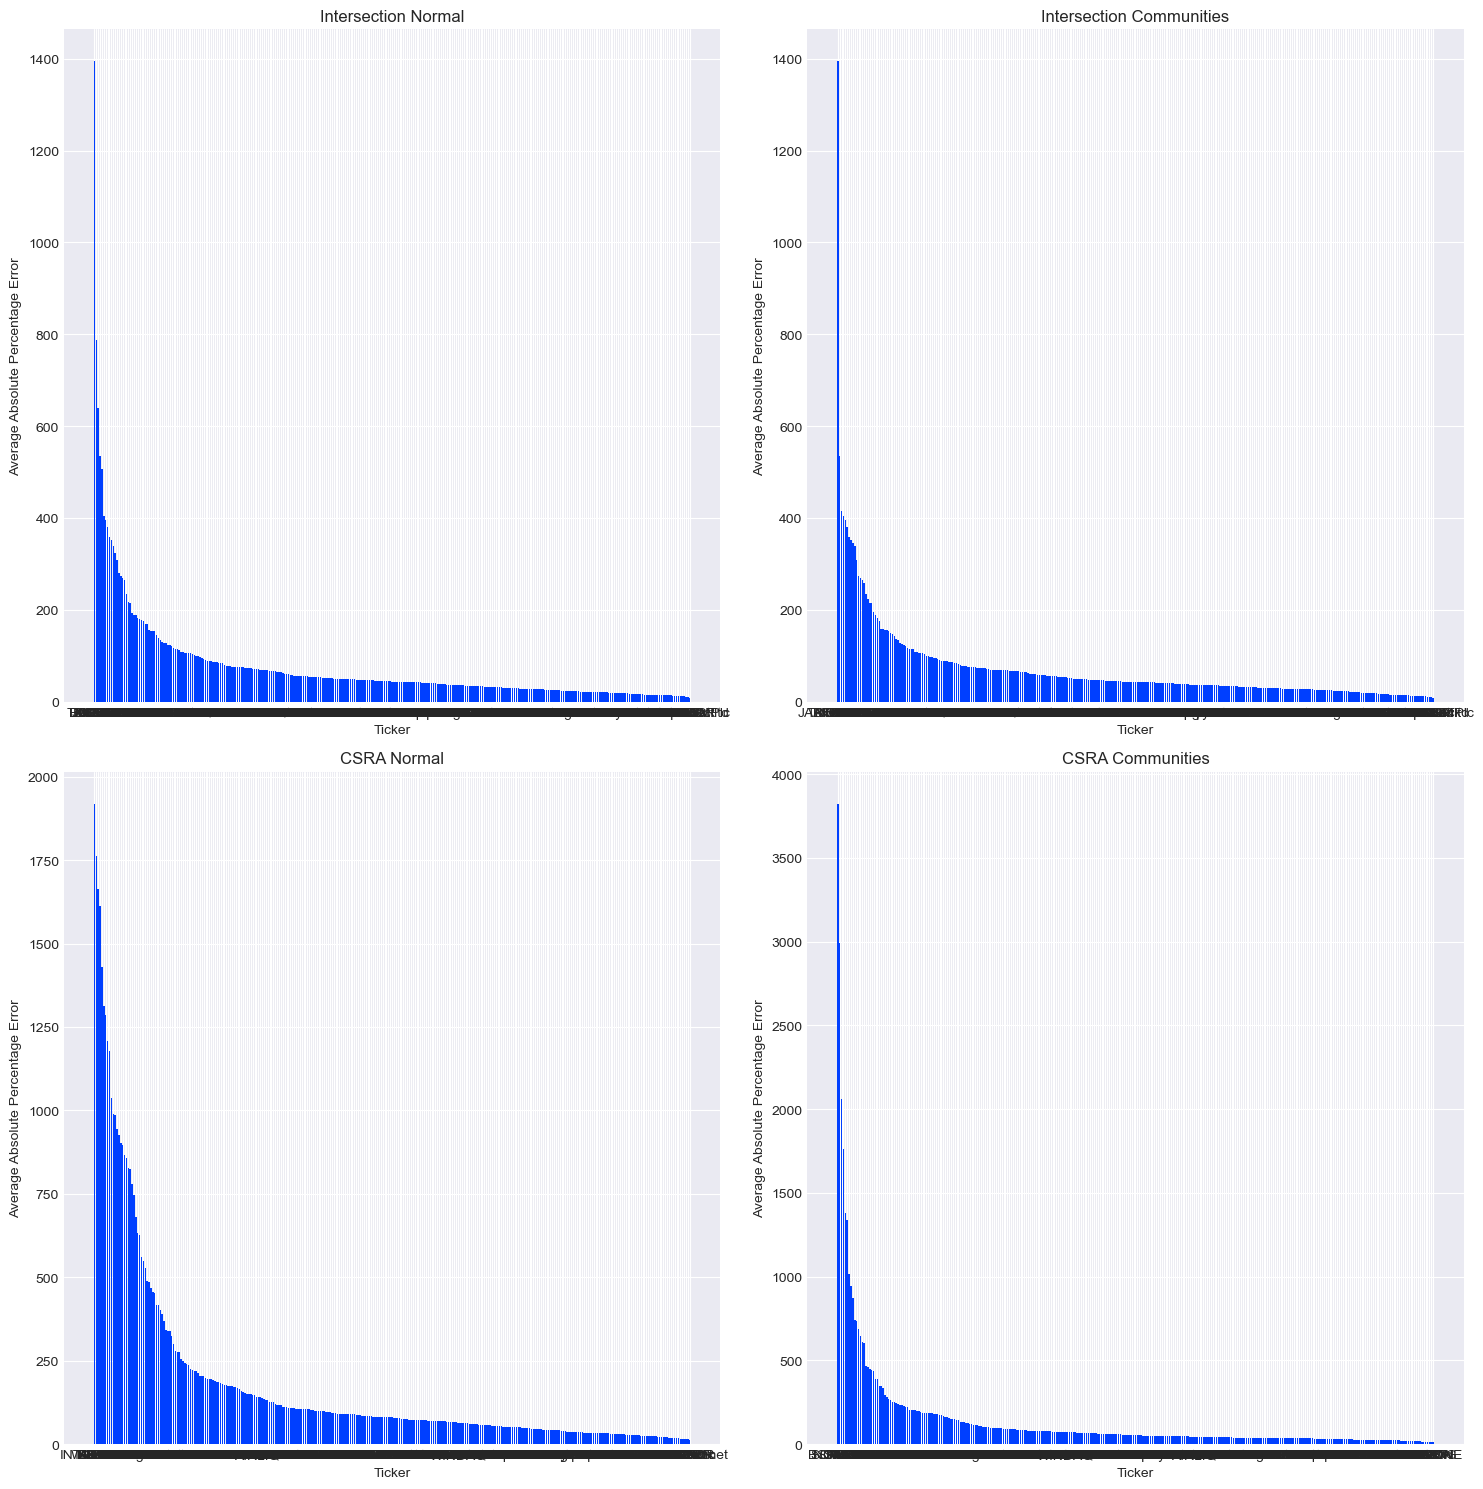

In [20]:
#Create sub plots showing the average absolute percentage error for each ticker for each method

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0, 0].bar(average_error_intersection_normal.index, average_error_intersection_normal.values)
axs[0, 0].set_title('Intersection Normal')
axs[0, 0].set_ylabel('Average Absolute Percentage Error')
axs[0, 0].set_xlabel('Ticker')

axs[0, 1].bar(average_error_intersection_communities.index, average_error_intersection_communities.values)
axs[0, 1].set_title('Intersection Communities')
axs[0, 1].set_ylabel('Average Absolute Percentage Error')
axs[0, 1].set_xlabel('Ticker')

axs[1, 0].bar(average_error_csra_normal.index, average_error_csra_normal.values)
axs[1, 0].set_title('CSRA Normal')
axs[1, 0].set_ylabel('Average Absolute Percentage Error')
axs[1, 0].set_xlabel('Ticker')

axs[1, 1].bar(average_error_csra_communities.index, average_error_csra_communities.values)
axs[1, 1].set_title('CSRA Communities')
axs[1, 1].set_ylabel('Average Absolute Percentage Error')
axs[1, 1].set_xlabel('Ticker')

plt.tight_layout()




In [ ]:
#Create sub plots showing the average absolute percentage error for each ticker for each method as a distribution. Make x axis intervals of 100

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0, 0].hist(average_error_intersection_normal.values, bins=100)
axs[0, 0].set_title('Intersection Normal')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_xlabel('Average Absolute Percentage Error')

axs[0, 1].hist(average_error_intersection_communities.values, bins=100)
axs[0, 1].set_title('Intersection Communities')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xlabel('Average Absolute Percentage Error')




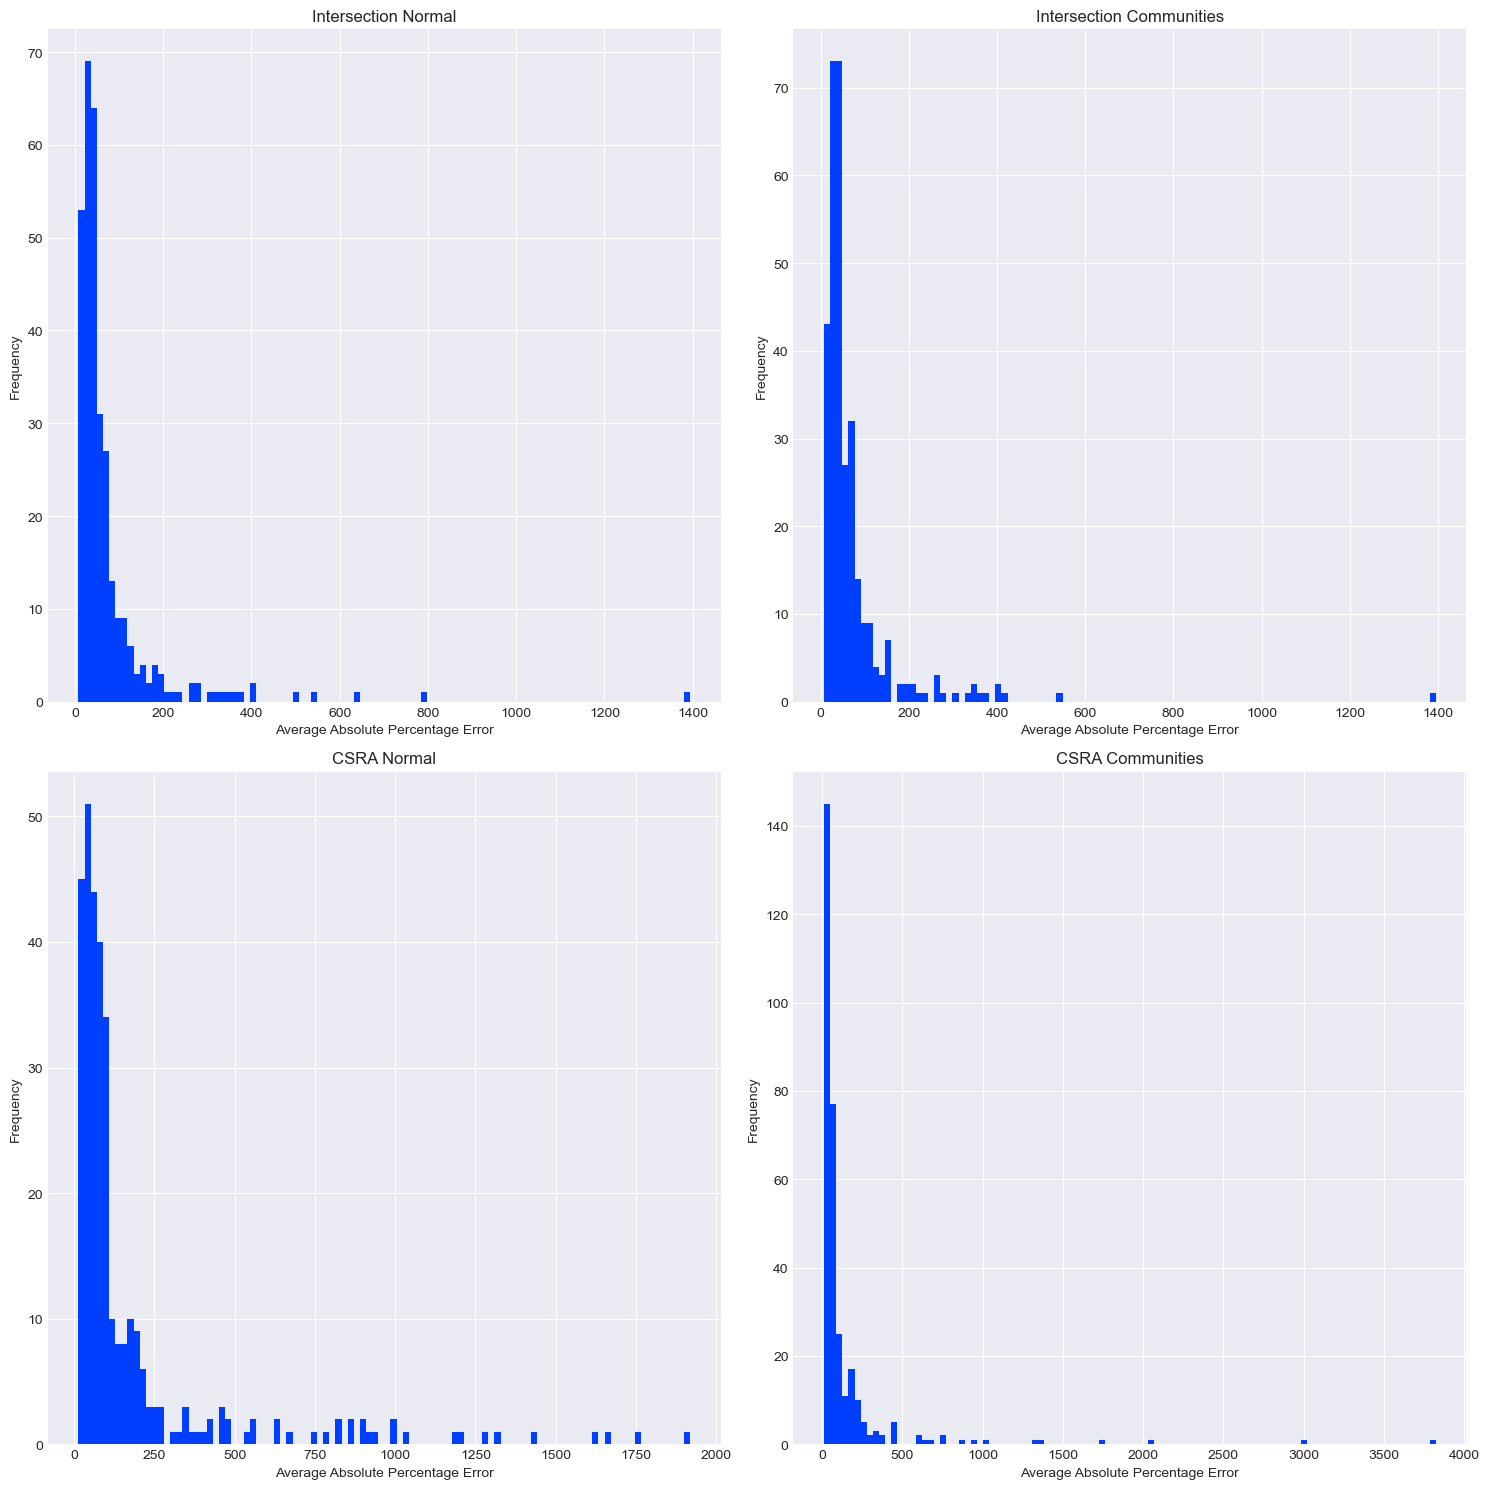

In [22]:
#Create sub plots showing the average absolute percentage error for each ticker for each method as a distribution. Make x axis intervals of 100

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0, 0].hist(average_error_intersection_normal.values, bins=100)
axs[0, 0].set_title('Intersection Normal')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_xlabel('Average Absolute Percentage Error')

axs[0, 1].hist(average_error_intersection_communities.values, bins=100)
axs[0, 1].set_title('Intersection Communities')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_xlabel('Average Absolute Percentage Error')

axs[1, 0].hist(average_error_csra_normal.values, bins=100)
axs[1, 0].set_title('CSRA Normal')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_xlabel('Average Absolute Percentage Error')

axs[1, 1].hist(average_error_csra_communities.values, bins=100)
axs[1, 1].set_title('CSRA Communities')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_xlabel('Average Absolute Percentage Error')

plt.tight_layout()


# Category Breakdown
---

* ###  Sector

In [26]:
#Sector
rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category = generate_rmse_curves_per_category('Sector',proxy_time_series_filtered,metadata)
average_rmse_per_category_df = create_results_table_for_category('Sector',metadata,rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category)
average_rmse_per_category_df

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Sector,Average_RMSE_Intersection_Normal,Average_RMSE_Intersection_Communities,Average_RMSE_CSRA_Normal,Average_RMSE_CSRA_Communities
0,Basic Materials,173.329225,168.379063,432.111336,252.879356
1,Industrials,152.772415,125.364836,195.657242,136.378311
2,Consumer Services,138.143142,139.106447,235.738083,140.283635
3,Financials,150.567624,151.634694,336.527267,251.608300
4,Utilities,138.025784,137.860375,215.158258,208.511379
5,Consumer Goods,112.108183,108.863239,177.494748,188.333486
6,Technology,178.365614,178.365614,825.722280,294.938249
7,Government,124.625794,124.625794,215.789823,202.830173
8,Health Care,45.143433,45.143433,47.094400,276.943700
9,Oil & Gas,53.304911,56.064692,176.216424,68.917085


* ### Rating

In [27]:
#Rating
rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category = generate_rmse_curves_per_category('AverageRating',proxy_time_series_filtered,metadata)
average_rmse_per_category_df = create_results_table_for_category('AverageRating',metadata,rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category)
average_rmse_per_category_df.sort_values(by='AverageRating')

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,AverageRating,Average_RMSE_Intersection_Normal,Average_RMSE_Intersection_Communities,Average_RMSE_CSRA_Normal,Average_RMSE_CSRA_Communities
11,1,29.906218,29.906218,602.896644,190.842857
12,2,54.882833,54.882833,214.367934,107.614354
8,3,31.534199,31.534199,299.645907,86.829217
13,4,42.088118,42.088118,33.680899,33.416779
3,5,19.723786,19.365828,363.530409,101.464677
7,6,33.295534,37.593227,383.231834,354.507366
4,7,40.363562,42.084767,141.874907,193.766514
9,8,53.993623,53.993623,216.785410,93.878477
1,9,116.349539,109.832281,458.225873,146.682181
2,10,170.527132,165.807815,273.689625,256.758083


* ### Country

In [28]:
#Country
rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category = generate_rmse_curves_per_category('Country',proxy_time_series_filtered,metadata)
average_rmse_per_category_df = create_results_table_for_category('Country',metadata,rmse_intersection_normal_list_category, rmse_intersection_communities_list_category, rmse_csra_normal_list_category, rmse_csra_communities_list_category)
average_rmse_per_category_df

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])
/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Country,Average_RMSE_Intersection_Normal,Average_RMSE_Intersection_Communities,Average_RMSE_CSRA_Normal,Average_RMSE_CSRA_Communities
0,United Kingdom,105.509342,106.738026,106.471954,97.664060
1,Spain,81.582567,81.582567,132.014910,124.173880
2,France,125.101988,122.604882,118.644597,131.359923
3,Italy,119.468363,117.618454,143.301672,253.030028
4,Germany,86.183078,89.628678,127.841946,160.138938
5,Netherlands,97.631074,100.812013,709.075537,181.314818
6,Belgium,76.918354,76.918354,419.972881,110.586402
7,Greece,773.336435,773.336435,780.997761,540.198560
8,Luxembourg,230.147408,221.914302,399.503438,255.541381
9,Sweden,177.772432,124.415131,156.745400,166.931360
